In [1174]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../../../data_set/train-data.csv', index_col=0)

df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [1175]:
df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

Controllo della variabile '**Mileage**'. Essa è espressa come stringa, nel formato '\<valore\> \<unità di misura\>'

In [1176]:
df['Mileage']

0       26.6 km/kg
1       19.67 kmpl
2        18.2 kmpl
3       20.77 kmpl
4        15.2 kmpl
           ...    
6014     28.4 kmpl
6015     24.4 kmpl
6016     14.0 kmpl
6017     18.9 kmpl
6018    25.44 kmpl
Name: Mileage, Length: 6019, dtype: object

Controlliamo se ci sono differenti unità di misura:

In [1177]:
mileage_units = df['Mileage'].str.split().str[-1]
mileage_units.unique()

array(['km/kg', 'kmpl', nan], dtype=object)

Notiamo che abbiamo due diverse unità 'km/kg' e 'kmpl'.

Vediamo per quante osservaioni appaiono le varie unità:

In [1178]:
mileage_units.value_counts()

Mileage
kmpl     5951
km/kg      66
Name: count, dtype: int64

Abbiamo visto che non ci sono errori o unità di misura fittizie, ci sono solamente alcuni valori mancanti. Vediamo quanti sono:

In [1179]:
mileage_units.isna().sum()

np.int64(2)

Abbiamo solo due valori mancanti che gestiremo in seguito.

Inoltre, notiamo che i vari valori di essa utilizzano differenti unità di misura. Questo accade perché tipicamente, per calcolare la quantità carburante consumato al chilometro, si utilizzano propreità diverse in base al tipo carburante dell'auto.

In genere:
- kmpl - chilometri al litro, usato per carburanti liquidi (benzina, diesel, GPL)
- km/kg - chilometri al chilogrammo, usato per carburanti diversi (CNG)

Vorremmo quindi, rimuovere o riempire i valori mancanti e sopratutto standardizzare le differenti unità di misura, in modo da averne solamente una.

Importante: ogni tipo di carburante ha una differente formula di conversione.

In [1180]:
df_2 = df[df['Mileage'].isna()]
df_2

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,NaN,72 CC,41 bhp,5.0,13.58 Lakh,13.00
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798 CC,73 bhp,5.0,NaN,12.75


Vediamo se ci sono valori insensati:

In [1181]:
df_copy = df.copy()

df_copy['Mileage'] = df_copy['Mileage'].str.split(' ').str[0]
df_copy['Mileage'] = pd.to_numeric(df_copy['Mileage'], errors='coerce')

# Fattori di conversione da km/l a km/kg
conversion_factors = {
    'Petrol': 1/0.74,   # approssimativo
    'Diesel': 1/0.85,   # approssimativo
    'LPG': 1/0.51,      # approssimativo
    'CNG': 1,            # già in km/kg
    'Electric': np.nan   # non convertibile
}

# Funzione di conversione per riga
def convert_kmpl_to_kmpkg(row):
    fuel = row['Fuel_Type']
    mileage = row['Mileage']
    # Se il valore non è valido o carburante non convertibile
    if pd.isna(mileage) or mileage <= 0 or fuel not in conversion_factors:
        return np.nan
    factor = conversion_factors[fuel]
    return mileage / factor

# Applico la conversione
df_copy['Mileage_kmpkg'] = df_copy.apply(convert_kmpl_to_kmpkg, axis=1)

# Calcolo la mediana dei valori validi
median_value = df_copy['Mileage_kmpkg'].median()

# Riempio i valori NaN (inclusi quelli inizialmente NaN o <=0)
df_copy['Mileage_kmpkg'] = df_copy['Mileage_kmpkg'].fillna(median_value)

df_copy['Mileage'] = df_copy['Mileage_kmpkg']

df_copy.drop(columns=['Mileage_kmpkg'], inplace=True)

In [1182]:
bad_values = df_copy.loc[df_copy['Mileage'] <= 0]
print(bad_values.value_counts())

Series([], Name: count, dtype: int64)


Convertiamo

| Fuel     | Potere calorifico | Conversione (L → kg) approssimativa       |
| -------- | ----------------- | ----------------------------------------- |
| Petrol   | 32 MJ/l           | 1 L ≈ 0.74 kg (32/43 MJ/kg)               |
| Diesel   | 36 MJ/l           | 1 L ≈ 0.85 kg (36/42 MJ/kg)               |
| LPG      | 25 MJ/l           | 1 L ≈ 0.51 kg (25/49 MJ/kg)               |
| CNG      | 50 MJ/kg          | 1 L ≈ ??? non serve, lo lasciamo in km/kg |
| Electric | -                 | non convertibile                          |


Dataset fino a **Correzione Inconsistenze e Formattazione**:

In [1183]:
df_clean = df.copy()

# Formattiamo bene 'Mileage'
# df_clean['Mileage'] = df_clean['Mileage'].str.split(' ').str[0]
# df_clean['Mileage'] = pd.to_numeric(df_clean['Mileage'], errors='coerce')

# Formattiamo bene 'Power'
df_clean['Power'] = df_clean['Power'].str.split(' ').str[0]
df_clean['Power'] = pd.to_numeric(df_clean['Power'], errors='coerce')

# Formattiamo bene 'New_Price'
df_clean['New_Price'] = df_clean['New_Price'].str.split(' ').str[0]
df_clean['New_Price'] = pd.to_numeric(df_clean['New_Price'], errors='coerce')

# Formattiamo bene 'New_Price'
df_clean['Engine'] = df_clean['Engine'].str.split(' ').str[0]
df_clean['Engine'] = pd.to_numeric(df_clean['Engine'], errors='coerce')

'Mileage' richiede una gestione apparte perché abbiamo due differenti unotà di misura:

In [1184]:
df_clean[df_clean['Fuel_Type'] == 'LPG']

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
5,Hyundai EON LPG Era Plus Option,Hyderabad,2012,75000,LPG,Manual,First,21.1 km/kg,814.0,55.20,5.0,NaN,2.35
936,Maruti Wagon R LXI LPG BSIV,Hyderabad,2012,72000,LPG,Manual,First,26.2 km/kg,998.0,58.20,5.0,NaN,2.85
987,Maruti Wagon R LXI DUO BSIII,Mumbai,2008,64226,LPG,Manual,First,17.3 km/kg,1061.0,57.50,5.0,NaN,1.45
2278,Hyundai Santro Xing GLS LPG,Pune,2010,55000,LPG,Manual,Second,13.45 km/kg,1086.0,62.10,5.0,NaN,1.65
2385,Hyundai Santro Xing GLS LPG,Hyderabad,2011,17000,LPG,Manual,First,13.45 km/kg,1086.0,62.10,5.0,NaN,3.10
2436,Hyundai i10 Magna LPG,Jaipur,2012,53000,LPG,Manual,Second,19.2 km/kg,1086.0,68.05,5.0,NaN,2.85
2941,Hyundai Santro Xing GL Plus LPG,Hyderabad,2014,56000,LPG,Manual,First,13.45 km/kg,1086.0,62.10,5.0,NaN,3.20
3595,Maruti Wagon R LX DUO BSIII,Hyderabad,2007,65047,LPG,Manual,First,17.3 km/kg,1061.0,57.50,5.0,NaN,1.95
5506,Maruti Wagon R Duo LX BSIII,Hyderabad,2012,72389,LPG,Manual,First,26.2 km/kg,998.0,58.20,5.0,NaN,3.20
5997,Maruti Wagon R Duo Lxi,Jaipur,2010,70000,LPG,Manual,First,26.2 km/kg,998.0,58.20,5.0,NaN,2.27


In [1185]:
df_clean2 = df.copy()

df_clean2['Mileage_Unit'] = df_clean2['Mileage'].str.split(' ').str[1]

expected_units = {
    'Petrol': 'kmpl',
    'Diesel': 'kmpl',
    'LPG': 'km/kg',
    'CNG': 'km/kg',
    'Electric': None
}

def check_consistency(row):
    expected = expected_units[row['Fuel_Type']]
    actual = row['Mileage_Unit']
    
    if row['Fuel_Type'] == 'Electric':
        return pd.isna(actual)
    
    return actual == expected

df_clean2['Mileage_Consistent'] = df_clean2.apply(check_consistency, axis=1)

consistency_report = (
    df_clean2
    .groupby('Fuel_Type')['Mileage_Consistent']
    .value_counts()
    .unstack(fill_value=0)
)

print(consistency_report)


Mileage_Consistent  True
Fuel_Type               
CNG                   56
Diesel              3205
Electric               2
LPG                   10
Petrol              2746


Se ci fossero state osservazioni inconsistenti avremmo avuto una colonna False contenenti i valori inconsistenti.

In [1186]:
# Fattori di conversione da km/l a km/kg
conversion_factors = {
    'Petrol': 1/0.74,   # kmpl → km/kg
    'Diesel': 1/0.85,   # kmpl → km/kg
    'LPG': None,        # già km/kg
    'CNG': None,        # già km/kg
    'Electric': None    # ← RESTA NaN
}

def convert_to_kmpkg(row):
    fuel = row['Fuel_Type']
    value = row['Mileage_Value']
    unit = row['Mileage_Unit']
    
    # Valore mancante
    if pd.isna(value):
        return np.nan
    
    # Electric → lasciamo NaN
    if fuel == 'Electric':
        return np.nan
    
    # Se è già in km/kg → lascia così
    if unit == 'km/kg':
        return value
    
    # Se è in kmpl → converti
    factor = conversion_factors[fuel]
    if unit == 'kmpl' and factor is not None:
        return value / factor
    
    return np.nan

# Estrazione numeri e unità in colonne separate
df_clean['Mileage_Value'] = df_clean['Mileage'].str.split(' ').str[0]
df_clean['Mileage_Value'] = pd.to_numeric(df_clean['Mileage_Value'], errors='coerce')

df_clean['Mileage_Unit'] = df_clean['Mileage'].str.split(' ').str[1]

# Applico la conversione
df_clean['Mileage_kmpkg'] = df_clean.apply(convert_to_kmpkg, axis=1)

median_value = df_clean['Mileage_kmpkg'].median()
df_clean['Mileage_kmpkg'] = df_clean['Mileage_kmpkg'].fillna(median_value)

# Rendo Mileage definitivo
df_clean['Mileage'] = df_clean['Mileage_kmpkg']

df_clean.drop(columns=['Mileage_kmpkg', 'Mileage_Value', 'Mileage_Unit'], inplace=True)

df_clean.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6000,998.0,58.16,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,16.7195,1582.0,126.20,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,13.4680,1199.0,88.70,5.0,8.61,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,17.6545,1248.0,88.76,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,12.9200,1968.0,140.80,5.0,NaN,17.74


In [1187]:
df_clean = df_clean.drop('New_Price', axis=1)

cols_to_impute = ['Power', 'Mileage', 'Engine', 'Seats']
df[cols_to_impute] = df_clean[cols_to_impute].replace(0.0, np.nan)

for col in cols_to_impute:
    median_value = df_clean[col].median()
    df_clean[col] = df_clean[col].fillna(median_value)

df_clean['Engine'] = df_clean['Engine'].astype('int64')
df_clean['Seats'] = df_clean['Seats'].astype('int64')

df_clean['Brand'] = df_clean['Name'].str.split(' ').str[0]
df_clean['Model'] = df_clean['Name'].str.split(' ').str[1]
df_clean = df_clean.drop('Name', axis=1)

df_clean.drop_duplicates(inplace=True)

In [1188]:
df_clean.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model
0,Mumbai,2010,72000,CNG,Manual,First,26.6000,998,58.16,5,1.75,Maruti,Wagon
1,Pune,2015,41000,Diesel,Manual,First,16.7195,1582,126.20,5,12.50,Hyundai,Creta
2,Chennai,2011,46000,Petrol,Manual,First,13.4680,1199,88.70,5,4.50,Honda,Jazz
3,Chennai,2012,87000,Diesel,Manual,First,17.6545,1248,88.76,7,6.00,Maruti,Ertiga
4,Coimbatore,2013,40670,Diesel,Automatic,Second,12.9200,1968,140.80,5,17.74,Audi,A4


### Gestione degli outliers

Controlleremo gli outliers in vari modi variabile per variabile.

Boxplots per variabili continue.

Controllo tramite limiti impostati da me, limiti sensati.

Usare boxplots per vedere quante osservazioni hanno alcune variabili categoriche.

**1. Year**

In [1189]:
df_clean['Year'].value_counts()

Year
2014    797
2015    744
2016    740
2013    649
2017    587
2012    580
2011    466
2010    342
2018    298
2009    198
2008    174
2007    124
2019    102
2006     78
2005     57
2004     31
2003     17
2002     15
2001      8
2000      4
1998      4
1999      2
Name: count, dtype: int64

Year non ha valori estremi, non ha outliers.

**2. Kilometers_Driven**

L'unico controllo che si potrebbe fare in Kilometers_Driven è vedere se ci sono osservazioni che hanno valore minore di zero per quella caratteristica.

In [1190]:
df_clean['Kilometers_Driven'].value_counts().sort_index()

Kilometers_Driven
171        1
600        1
1000       9
1001       2
1011       1
          ..
480000     2
620000     1
720000     1
775000     1
6500000    1
Name: count, Length: 3093, dtype: int64

Notiamo che il chilometraggio minimo sembra sensato, tuttavia c'è un auto che ha ben 6 milioi di km percorsi, è molto improbabile. Siamo senza dubbio di fronte ad un outlier. Si deve gestire.

In [1191]:
df_clean[df_clean['Kilometers_Driven'] > 1000000]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model
2328,Chennai,2017,6500000,Diesel,Automatic,First,13.5745,2993,258.0,5,65.0,BMW,X5


In [1192]:
df_clean[df_clean['Kilometers_Driven'] < 10].value_counts()

Series([], Name: count, dtype: int64)

**3. Mileage**

In [1193]:
df_clean['Mileage'].value_counts().sort_index()

Mileage
0.0000     68
4.7360      1
5.7794      1
5.8756      2
5.9200      1
           ..
30.4600     1
31.7900     2
32.2600     2
33.4400     4
33.5400     5
Name: count, Length: 533, dtype: int64

In [1194]:
df_clean[(df_clean['Mileage'] <= 0) & (df_clean['Fuel_Type'] != 'Electric')].value_counts()


Location   Year  Kilometers_Driven  Fuel_Type  Transmission  Owner_Type  Mileage  Engine  Power  Seats  Price  Brand          Model  
Ahmedabad  2005  58000              Petrol     Manual        Second      0.0      999     97.7   5      1.51   Hyundai        Santro     1
           2007  60006              Petrol     Manual        First       0.0      1493    97.7   5      2.95   Honda          City       1
           2012  66000              Diesel     Automatic     First       0.0      2987    165.0  5      23.00  Mercedes-Benz  M-Class    1
           2019  4000               Diesel     Automatic     First       0.0      1950    194.0  5      35.00  Mercedes-Benz  C-Class    1
Bangalore  2002  53000              Petrol     Manual        Second      0.0      1493    97.7   5      1.85   Honda          City       1
                                                                                                                                        ..
Pune       2009  100000         

Notiamo che 68 osservazioni non hanno un valore accettabile per Mileage, questi sono senza dubbio outliers. Possiamo gestirli assegnando a questi valori la mediana del valore di Mileage, più robusta ad altri eventuali outliers non identificati.

In [1195]:
# Calcolo mediana solo per le auto non elettriche con Mileage > 0
mileage_median = df_clean.loc[
    (df_clean['Mileage'] > 0) & (df_clean['Fuel_Type'] != 'Electric'),
    'Mileage'
].median()

# Sostituisco solo i valori <= 0 (non elettriche)
df_clean.loc[
    (df_clean['Mileage'] <= 0) & (df_clean['Fuel_Type'] != 'Electric'),
    'Mileage'
] = mileage_median

In [1196]:
df_clean[(df_clean['Mileage'] <= 0) & (df_clean['Fuel_Type'] != 'Electric')].value_counts()

Series([], Name: count, dtype: int64)

**4. Engine**

In [1197]:
df_clean['Engine'].value_counts().sort_index()

Engine
72        1
624      25
793       4
796     128
799      36
       ... 
4951      1
5000      2
5204      1
5461      3
5998      1
Name: count, Length: 146, dtype: int64

Non sembrano esserci outliers. Tuttavia andiamo a controllare se osservazioni che hanno un alto valore di Engine (motore potente), rispettino la potenza Power dell'auto. Lo facciamo visualizzando uno Scatter Plot.

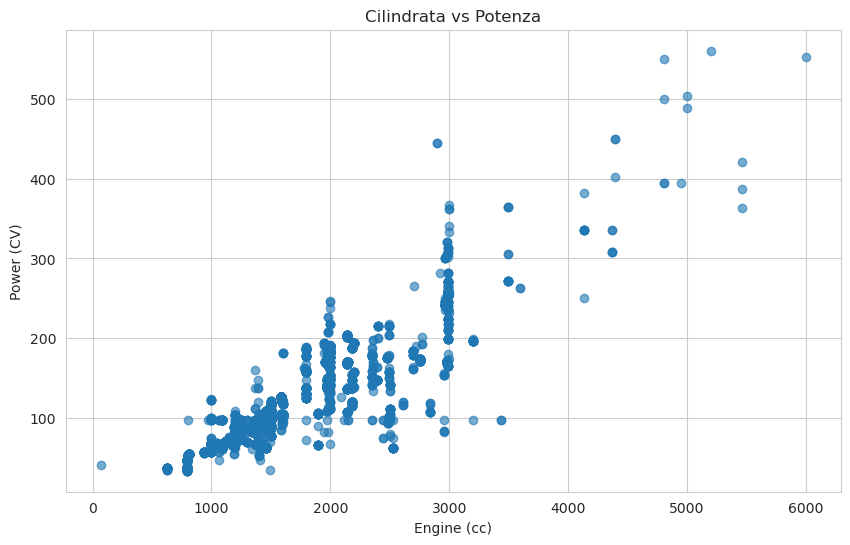

In [1198]:
plt.figure(figsize=(10,6))
plt.scatter(df_clean['Engine'], df_clean['Power'], alpha=0.6)
plt.xlabel('Engine (cc)')
plt.ylabel('Power (CV)')
plt.title('Cilindrata vs Potenza')
plt.grid(True)
plt.show()

Non sembrano esserci outliers.

**5. Power**


In [1199]:
df_clean['Power'].value_counts().sort_index()

Power
34.20      7
35.00     17
35.50      1
37.00     12
37.48     12
          ..
500.00     1
503.00     1
550.00     1
552.00     1
560.00     1
Name: count, Length: 369, dtype: int64

Non sembrano esserci outliers

**6. Seats**

In [1200]:
df_clean['Seats'].value_counts().sort_index()

Seats
0        1
2       16
4       99
5     5054
6       31
7      674
8      134
9        3
10       5
Name: count, dtype: int64

In [1201]:
df_clean[df_clean['Seats'] < 1]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model
3999,Hyderabad,2012,125000,Petrol,Automatic,First,7.77,3197,97.7,0,18.0,Audi,A4


Siamo di frontw ad un outlier, dobbiamo gestilo, potremmo riempirlo con un valore sensato: 4 ad esempio.

**7. Price**

In [1202]:
df_clean['Price'].value_counts().sort_index()

Price
0.44      1
0.45      3
0.50      2
0.51      1
0.53      2
         ..
93.67     1
97.07     1
100.00    1
120.00    1
160.00    1
Name: count, Length: 1373, dtype: int64

---

## Fase 2.3: Analisi Esplorativa

In [1203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('dataframe.csv')

df.head()

,Brand,Model,Location,Age,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Hyundai,Creta,Pune,4,41000.0,Diesel,Manual,First,19.67,1582,126.20,5,2.602690
1,Honda,Jazz,Chennai,8,46000.0,Petrol,Manual,First,18.20,1199,88.70,5,1.704748
2,Maruti,Ertiga,Chennai,7,87000.0,Diesel,Manual,First,20.77,1248,88.76,7,1.945910
3,Audi,A4,Coimbatore,6,40670.0,Diesel,Automatic,Second,15.20,1968,140.80,5,2.930660
4,Nissan,Micra,Jaipur,6,86999.0,Diesel,Manual,First,23.08,1461,63.10,5,1.504077


### Analisi Univariata

Analisi di **Age**. (L'ha fatta anche pippo)

In [1204]:
age = df['Age']
age.describe()

count    5865.000000
mean        5.491901
std         3.028848
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        14.000000
Name: Age, dtype: float64

Notiamo che il 50% delle auto rivendute ha tra i 3 e i 7 anni. Significa che auto più vecchie coprono meno fetta di mercato

Abbiamo già varie informazioni circa Age, ma visualizziamole in maniera migliore:


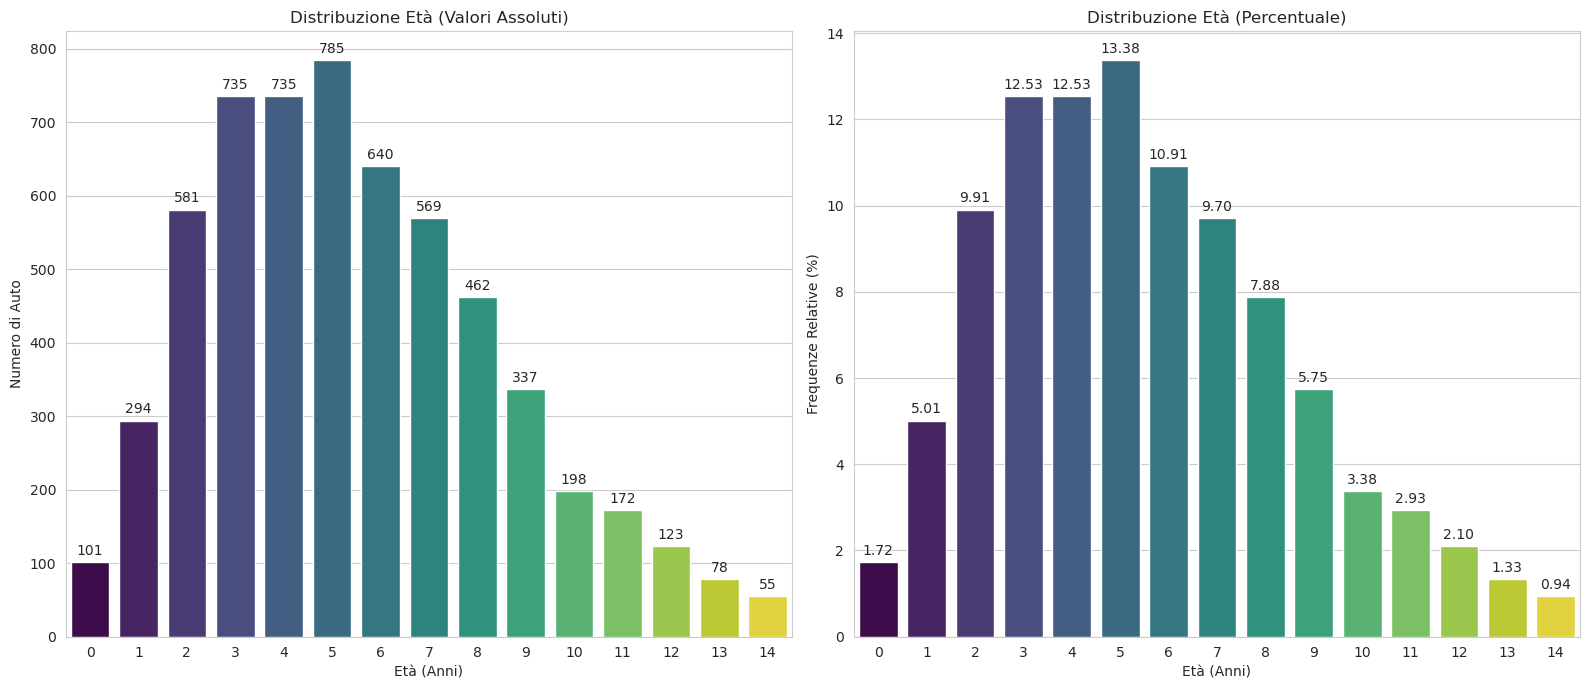

In [1205]:
counts_abs = df['Age'].value_counts().sort_index()
counts_rel = (df['Age'].value_counts(normalize=True).sort_index()) * 100

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
ax1 = sns.barplot(
    x=counts_abs.index, 
    y=counts_abs.values, 
    hue=counts_abs.index, 
    palette='viridis', 
    legend=False
)

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', padding=3, fontsize=10)

plt.title('Distribuzione Età (Valori Assoluti)')
plt.xticks(rotation=0)
plt.ylabel('Numero di Auto')
plt.xlabel('Età (Anni)')


plt.subplot(1, 2, 2)
ax2 = sns.barplot(
    x=counts_rel.index, 
    y=counts_rel.values, 
    hue=counts_rel.index, 
    palette='viridis', 
    legend=False
)

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Distribuzione Età (Percentuale)')
plt.xticks(rotation=0)
plt.ylabel('Frequenze Relative (%)')
plt.xlabel('Età (Anni)')

plt.tight_layout()
plt.show()

La moda per *'Age'* è 

Analisi di **Transmission**

In [1206]:
transmission = df['Transmission']
transmission.describe()

count       5865
unique         2
top       Manual
freq        4157
Name: Transmission, dtype: object

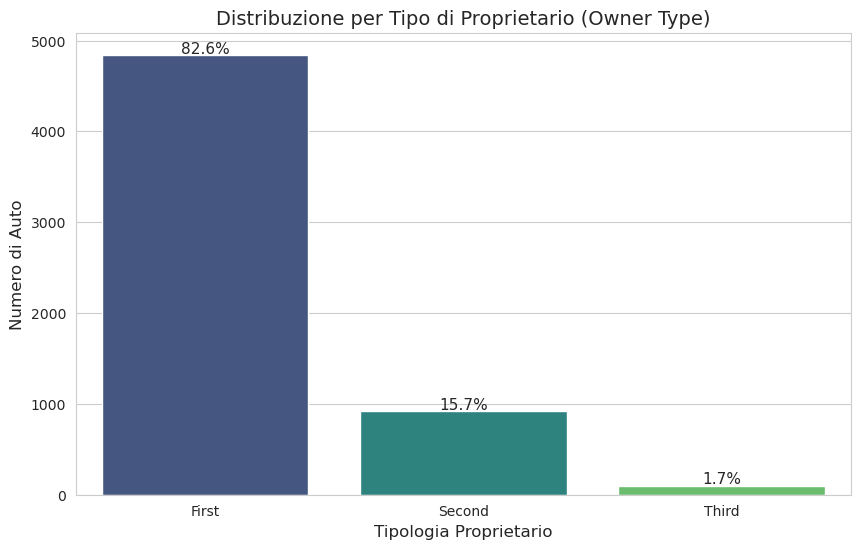

In [1207]:
sns.set_style("whitegrid")

owner_counts = df['Owner_Type'].value_counts()

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x=owner_counts.index, 
    y=owner_counts.values, 
    palette="viridis",
    hue=owner_counts.index,
    legend=False
)

plt.title("Distribuzione per Tipo di Proprietario (Owner Type)", fontsize=14)
plt.xlabel("Tipologia Proprietario", fontsize=12)
plt.ylabel("Numero di Auto", fontsize=12)

for i, v in enumerate(owner_counts.values):
    pct = (v / len(df)) * 100
    plt.text(i, v + 20, f"{pct:.1f}%", ha='center', fontsize=11)

plt.show()

Come già sapevamo abbiamo due diversi tipi di cambio per le auto: 'Manual' e 'Automatic'. Notiamo che la maggior parte delle auto vendute sono Manuali con ben il 71% del mercato.

Analisi di **Owner_Type**

Un auto di seconda in genere ha molto più valore di un auto di terza o quarta mano.

In [1208]:
df['Owner_Type'].describe()

count      5865
unique        3
top       First
freq       4844
Name: Owner_Type, dtype: object

Distribuzione Owner Type:
  Proprietari  Frequenza  Percentuale (%)
0       First       4844        82.591645
1      Second        920        15.686275
2       Third        101         1.722080
------------------------------


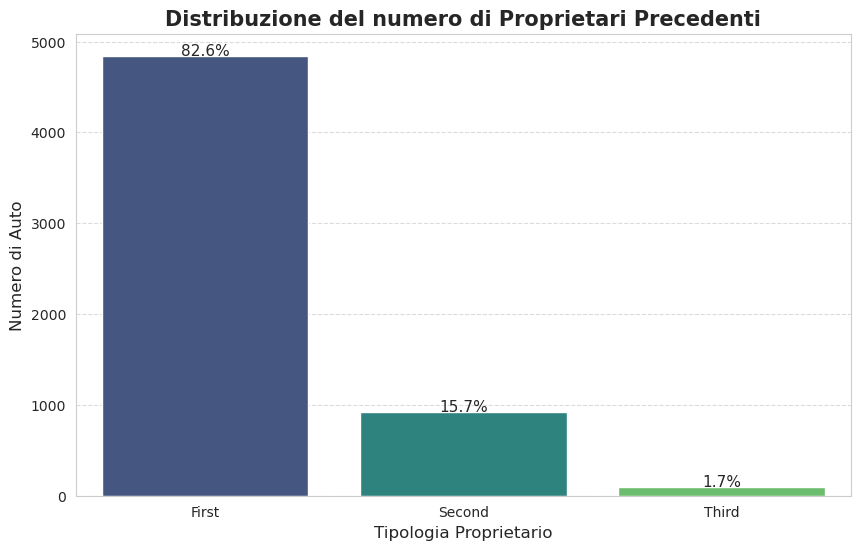

In [1209]:
owner_counts = df['Owner_Type'].value_counts().reset_index()
owner_counts.columns = ['Proprietari', 'Frequenza']
owner_counts['Percentuale (%)'] = (owner_counts['Frequenza'] / len(df)) * 100

print("Distribuzione Owner Type:")
print(owner_counts)
print("-" * 30)

plt.figure(figsize=(10, 6))

order = owner_counts['Proprietari'] 

ax = sns.barplot(
    x='Proprietari', 
    y='Frequenza', 
    hue='Proprietari',
    data=owner_counts, 
    order=order,
    palette='viridis',
    legend=False
)

plt.title('Distribuzione del numero di Proprietari Precedenti', fontsize=15, fontweight='bold')
plt.xlabel('Tipologia Proprietario', fontsize=12)
plt.ylabel('Numero di Auto', fontsize=12)

for p in ax.patches:
    height = p.get_height()
    
    if height > 0:
        percentage = '{:.1f}%'.format(100 * height / len(df))
        ax.text(p.get_x() + p.get_width() / 2., height + 5, percentage, ha="center", fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

La distribuzione è fortemente dominata dalla categoria *'First Owner'*, che copre circa l'83% dei casi. Quindi il dataset è composto prevalentemente da veicoli 'giovani' e ben mantenuti.

Notiamo un calo passando da *'Second'* a *'Third*' hand. Le auto con 3 o più propreitari sono statisticamente trascurabili.

Nota: Essendo una variabile ordinale, in fase di modeling potremmo assegnare dei valori numerici ad ogni etichetta. Inoltre potremmo combinare in una sola etichetta '*Third*' e '*Fourth & Above*', essenco che sono entrambe statisticamente trascurabili.

Analisi di **Mileage**.

In [1210]:
mileage = df['Mileage']
mileage.describe()

count    5865.000000
mean       18.305062
std         4.075279
min         6.400000
25%        15.400000
50%        18.200000
75%        21.100000
max        28.400000
Name: Mileage, dtype: float64

Conclusione 1 (Dispersione): 
- La deviazione standard di 3.79 (che è circa il 25% della media) indica che il campione è eterogeneo. La performance di un'auto tipica si discosta dalla media per circa 3.8 km/kg.

Conclusione 2 (Asimmetria): 
- Poiché la Media (14.77) > Mediana (13.99), la distribuzione è asimmetrica verso destra. Ciò significa che ci sono relativamente poche auto che hanno un consumo molto più alto della media (sono le auto molto efficienti).


Costruiamo un grafico delle frequenze assolute e relative utilizzando gli istogrammi, scelgo Rice per detrminare il numero di bins:

Num. of bins: 36


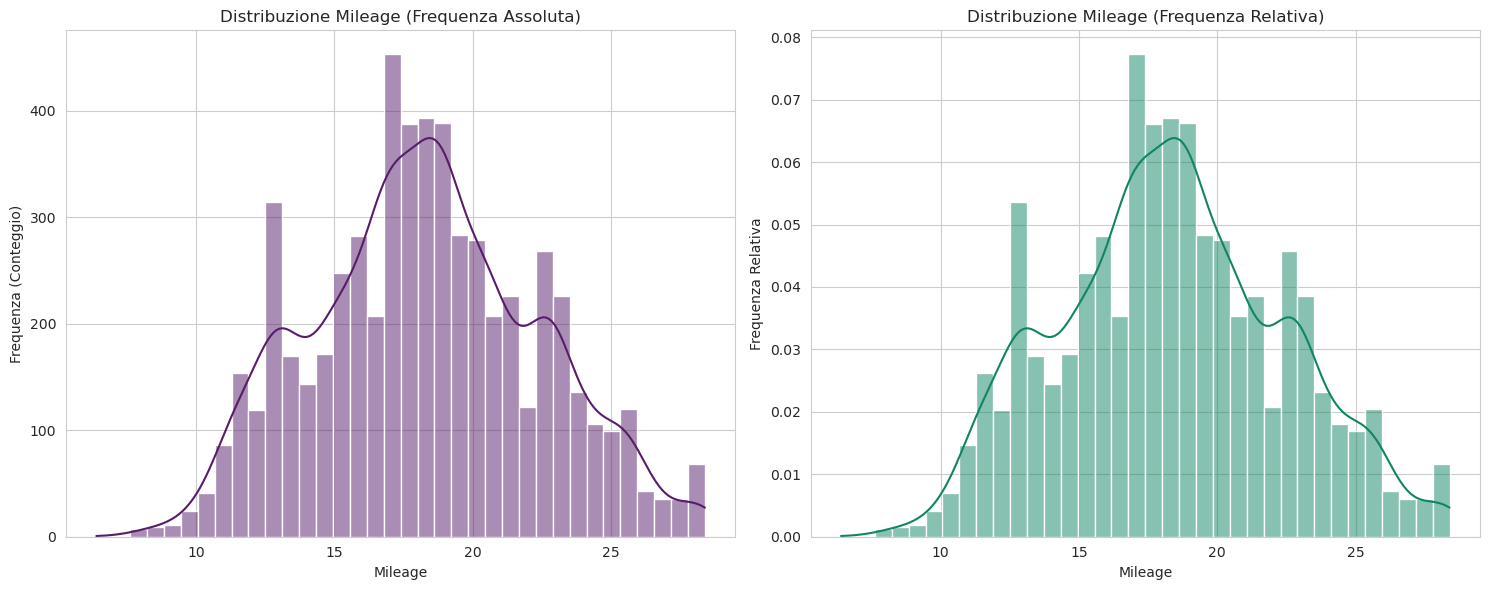

In [1211]:

n = len(mileage)
rice_bins = int(2 * n**(1/3))

print(f"Num. of bins: {rice_bins}")

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1) 
ax1 = sns.histplot(
    x=mileage, 
    bins=rice_bins, 
    kde=True, 
    color="#571c6a",
    edgecolor='white'
)
plt.title(f'Distribuzione Mileage (Frequenza Assoluta)')
plt.ylabel('Frequenza (Conteggio)')
plt.xlabel('Mileage')

plt.subplot(1, 2, 2) 
ax2 = sns.histplot(
    x=mileage, 
    bins=rice_bins, 
    kde=True, 
    stat='probability',
    color="#108564",
    edgecolor='white'
)
plt.title(f'Distribuzione Mileage (Frequenza Relativa)')
plt.ylabel('Frequenza Relativa')
plt.xlabel('Mileage')

plt.tight_layout()
plt.show()

Come ci si aspettava notiamo un'assimmetria verso destra. Inoltre la moda sembra essere circa 13 km/kg, più del 12% delle auto hanno quel consumo. 

La distribuzione non segue la normale perfettamente.

To do: linee per determinare la media, mediana , IQR, poi uso di box plots

Calcoliamo i valori di skewness e kurtosis:

In [1212]:
print(f"Skewness: {mileage.skew():.2f}")
print(f"Kurtosis: {mileage.kurtosis():.2f}")

Skewness: 0.13
Kurtosis: -0.45


Il valore di skewness ci suggerisce infatti un'assimmetria a destra. Inoltre il valore di kurtosis ci indica che abbiamo un picco più appuntito e code più pesanti rispetto alla normale.

Visualizziamo adesso il boxplot per visualizzare gli outlier:

<Axes: >

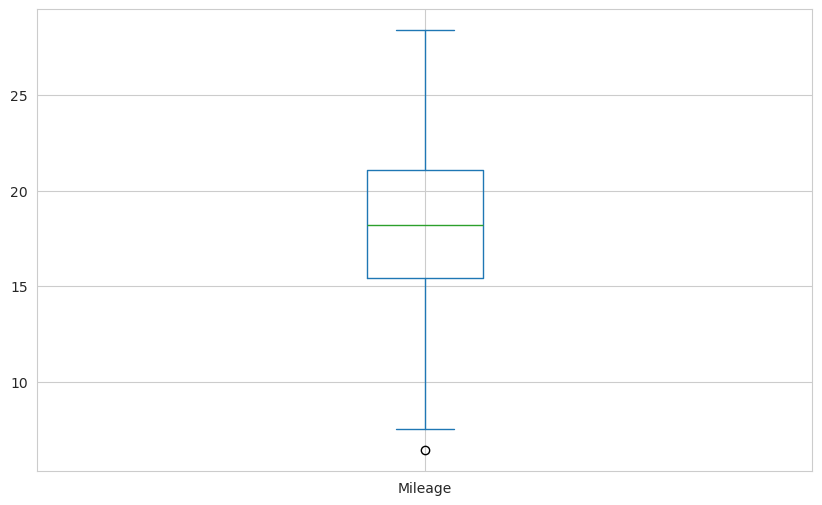

In [1213]:
mileage.plot.box(figsize=(10,6))

Notiamo alcuni valori anomali che superano di molto il la media: potrebbero essere veicoli alimentati in maniera differente, più efficiente energeticamente.

Analizziamo **Engine**.

In [1214]:
engine = df['Engine']

engine.describe()

count    5865.000000
mean     1628.979710
std       599.509524
min       624.000000
25%      1198.000000
50%      1495.000000
75%      1991.000000
max      5998.000000
Name: Engine, dtype: float64

Innanzitutto il 50% dei motori ha tra 1200 e 1984 CC di cilindrata. C'è molta varianza nei dati, essendo che la media è più grande della mediana ma non di molto significa che abbiamo alcuni valori maggiori. Ma abbiamo anche valori molto grandi, probabilmente auto sportive che hanno motori più potenti.

Num. of bins: 36


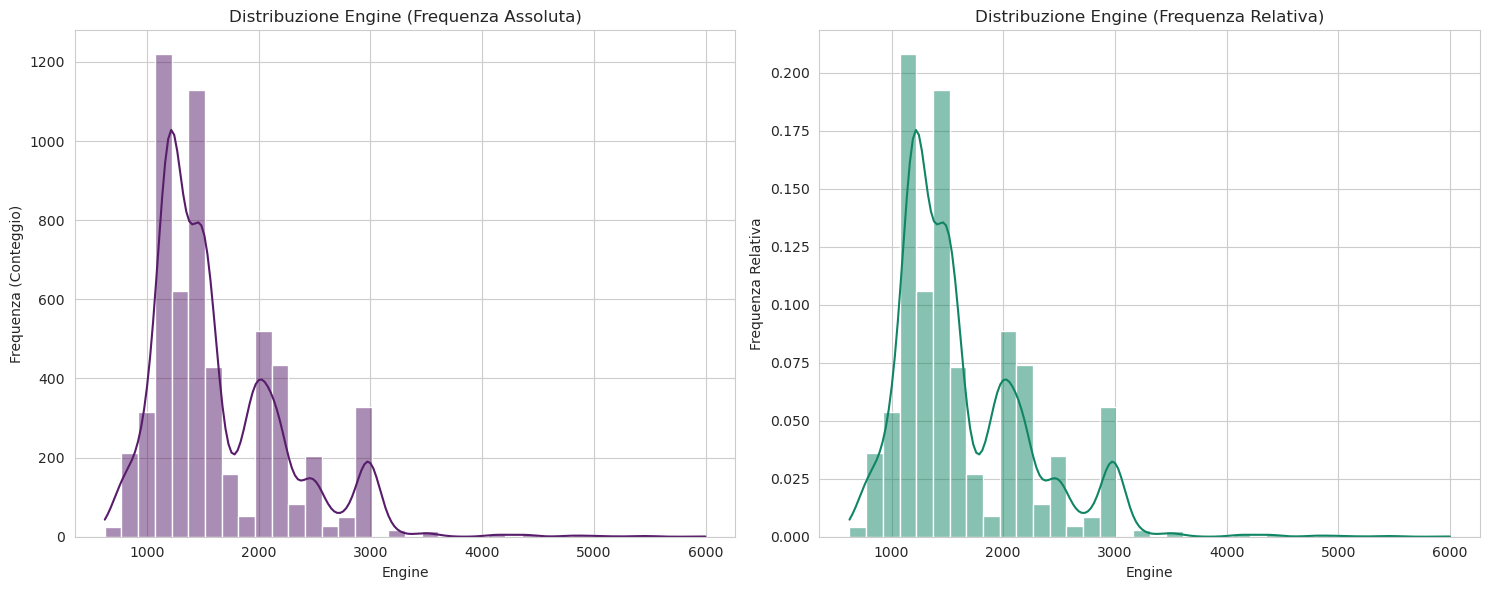

In [1215]:

n = len(engine)
rice_bins = int(2 * n**(1/3))

print(f"Num. of bins: {rice_bins}")

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1) 
ax1 = sns.histplot(
    x=engine, 
    bins=rice_bins, 
    kde=True, 
    color="#571c6a",
    edgecolor='white'
)
plt.title(f'Distribuzione Engine (Frequenza Assoluta)')
plt.ylabel('Frequenza (Conteggio)')
plt.xlabel('Engine')

plt.subplot(1, 2, 2) 
ax2 = sns.histplot(
    x=engine, 
    bins=rice_bins, 
    kde=True, 
    stat='probability',
    color="#108564",
    edgecolor='white'
)
plt.title(f'Distribuzione Engine (Frequenza Relativa)')
plt.ylabel('Frequenza Relativa')
plt.xlabel('Engine')

plt.tight_layout()
plt.show()

I dati non sono distribuiti benissimo secondo la normale. Notiamo che abbiamo pochissime auto che superano i 3000 di cilindrata, auesto perché in genere motori più potenti sono montati su auto più costose che hanno meno mercato, inoltre la moda è di circa 1300 CC.

In più la distribuzione è molto estesa verso destra, come visto prima c'è una certa varianza nei valori.

Calcoliamo adesso la Skewness e Kurtosis:

In [1216]:
print(f"Skewness: {engine.skew():.2f}")
print(f"Kurtosis: {engine.kurtosis():.2f}")

Skewness: 1.44
Kurtosis: 3.18


La Skewness ci indica che c'è una significativa asimmetria verso destra, potrebbe indicare che la maggior parte delle vendite riguardano auto economiche, utilitarie quindi con bassi CC; mentre Kurtosis ci mostra che la distribuzione è più appuntita rispetto la normale.

Visualizziamo adesso il boxplot per visualizzare gli outlier:

<Axes: >

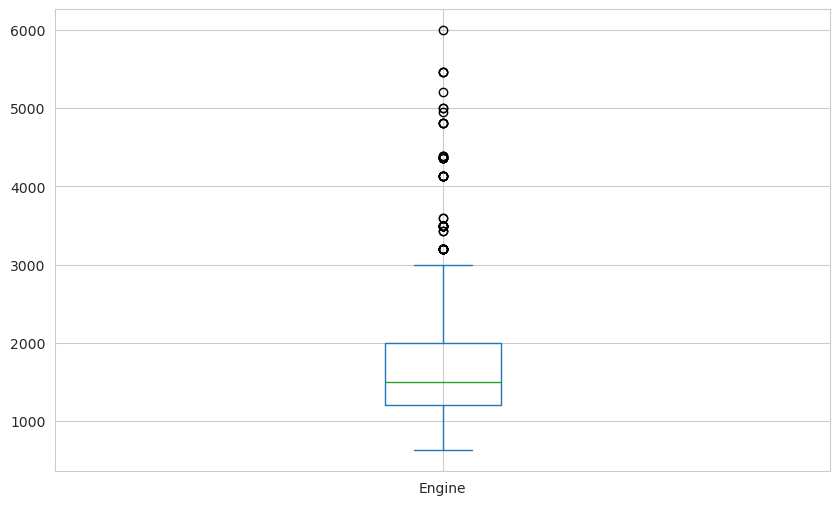

In [1217]:
engine.plot.box(figsize=(10,6))

Il 50% delle auto vendute è apunto racchiuso un un intervallo non troppo esteso. Inoltre, come abbiamo visto prima, la distribuzione è molto estesa per valori alti.

Analizziamo **'Power'**.

In [1218]:
power = df['Power']
power.describe()

count    5865.000000
mean      113.832766
std        53.377173
min        34.200000
25%        78.900000
50%        97.700000
75%       138.100000
max       560.000000
Name: Power, dtype: float64

Notiamo che il 50% delle osservazioni ha tra i 78 e i 138 cavalli, ma il massimo di discosta di molto, sempre per gli stessi motivi elencati per Engine, infatti la potenza dell'auto e la cilindrata del motore sono due caratteristiche molto correlate.

Ci aspettiamo che Power abbia una distribuzione simile a Engine.

Num. of bins: 36


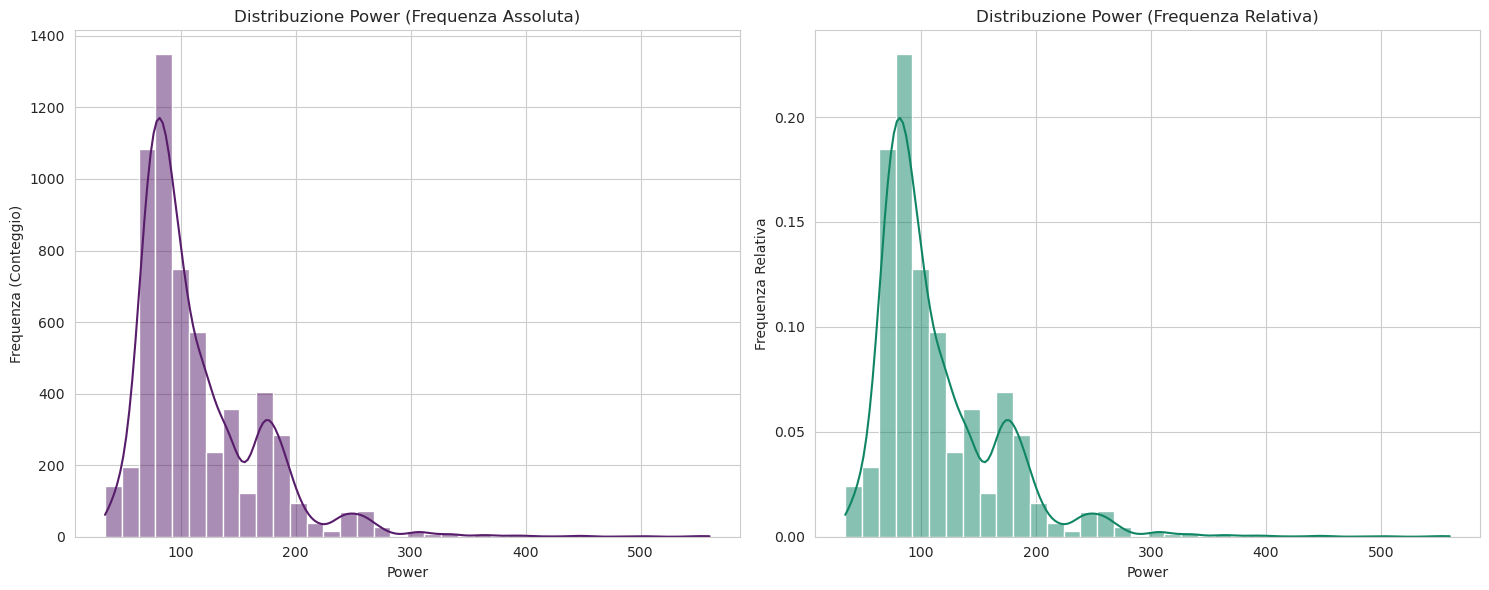

In [1219]:

n = len(power)
rice_bins = int(2 * n**(1/3))

print(f"Num. of bins: {rice_bins}")

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1) 
ax1 = sns.histplot(
    x=power, 
    bins=rice_bins, 
    kde=True, 
    color="#571c6a",
    edgecolor='white'
)
plt.title(f'Distribuzione Power (Frequenza Assoluta)')
plt.ylabel('Frequenza (Conteggio)')
plt.xlabel('Power')

plt.subplot(1, 2, 2) 
ax2 = sns.histplot(
    x=power, 
    bins=rice_bins, 
    kde=True, 
    stat='probability',
    color="#108564",
    edgecolor='white'
)
plt.title(f'Distribuzione Power (Frequenza Relativa)')
plt.ylabel('Frequenza Relativa')
plt.xlabel('Power')

plt.tight_layout()
plt.show()

Come detto prima, ha un distribuzione molto simile a quella di Power. La moda è circa 95 cavalli con quasi 1400 osservazioni.
Vediamo sempre una distribuzione fortemente asimmetrica verso destra.

Vediamo Skewness e Kurtosis:

In [1220]:
print(f"Skewness: {power.skew():.2f}")
print(f"Kurtosis: {power.kurtosis():.2f}")

Skewness: 1.96
Kurtosis: 6.77


Inoltre Power si discosta ancora di più dalla normale. Anche se i cavalli sono determinati dalla cilindrata ci sono anche altri fattori che influenzano tale dato, ad esempio la qualità di costruzione del motore o quanto efficientemente viene gestito il carburante.

Visualizziamo adesso il boxplot per visualizzare gli outlier:

<Axes: >

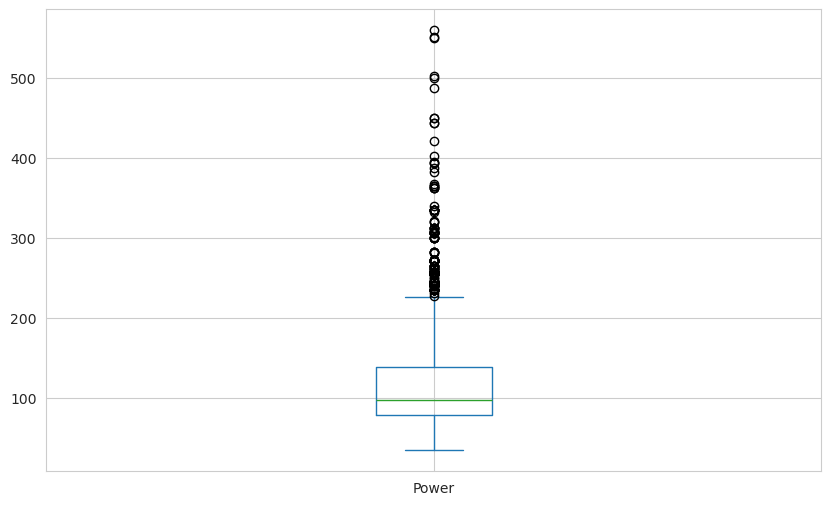

In [1221]:
power.plot.box(figsize=(10,6))

In power l'asimmetria è ancora più accentuata, abbiamo molti valori che vengono considerati outlier, questi rappresentano il segmento auto sportive probabilmente.

Analizziamo **Seats**.

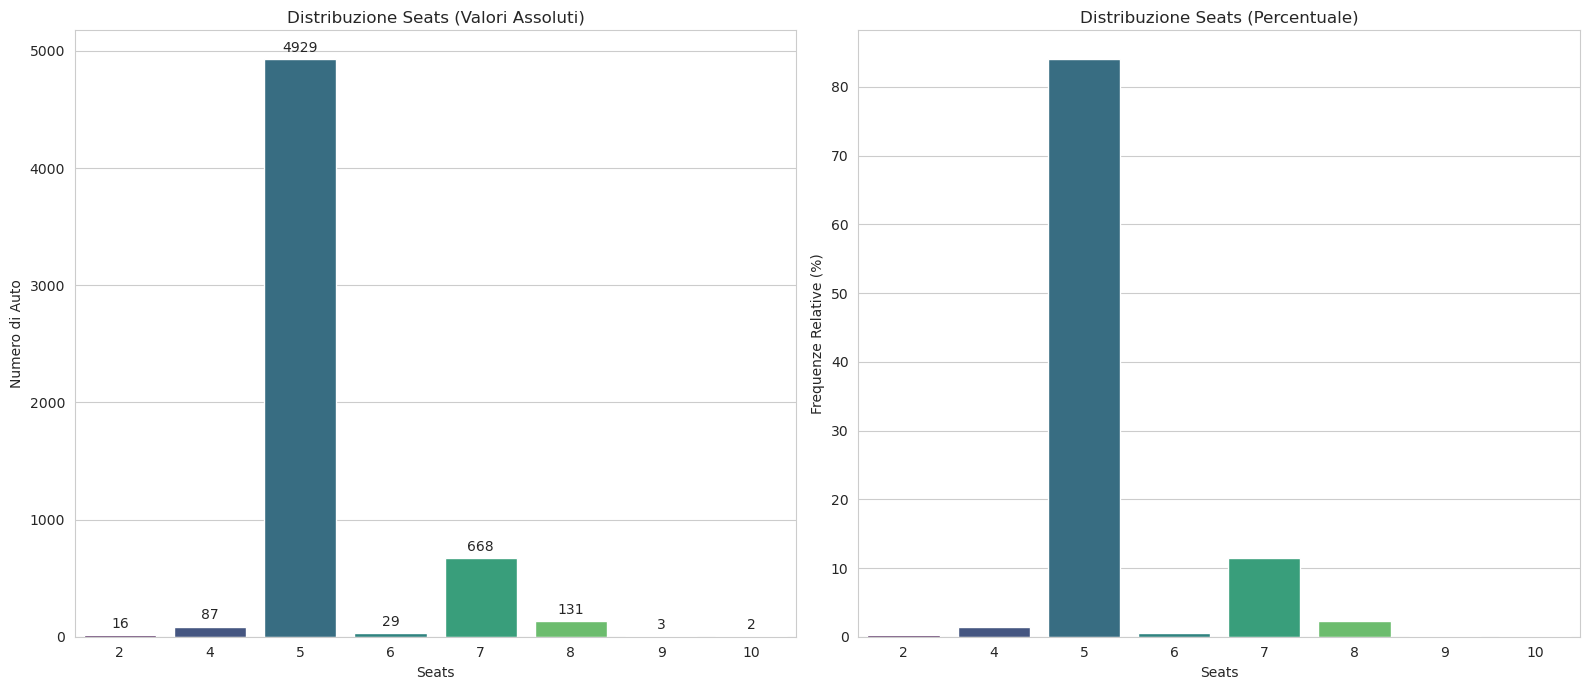

In [1222]:
seats = df['Seats']

seats_abs = seats.value_counts().sort_index()
seats_rel = (seats.value_counts(normalize=True).sort_index()) * 100

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
ax1 = sns.barplot(
    x=seats_abs.index, 
    y=seats_abs.values, 
    hue=seats_abs.index, 
    palette='viridis', 
    legend=False
)

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', padding=3, fontsize=10)

plt.title('Distribuzione Seats (Valori Assoluti)')
plt.xticks(rotation=0)
plt.ylabel('Numero di Auto')
plt.xlabel('Seats')


plt.subplot(1, 2, 2)
ax2 = sns.barplot(
    x=seats_rel.index, 
    y=seats_rel.values, 
    hue=seats_rel.index, 
    palette='viridis', 
    legend=False
)

# for container in ax2.containers:
#     ax2.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Distribuzione Seats (Percentuale)')
plt.xticks(rotation=0)
plt.ylabel('Frequenze Relative (%)')
plt.xlabel('Seats')

plt.tight_layout()
plt.show()


Notiamo come il mercato è fortemente dominato da auto a 5 posti, le più diffure. Con un fetta non trascurabile di auto a 7 posti, suv o auto familiari probabilmente. Auto a 10 e 9 posti sono statisticamente trascurabili.

Analisi di **'Price'**.

Ricordiamo che il prezzo è espresso in Lahks, in cui 1 unità di Lahks equivale a 100.000. Quindi questi pressi devono essere moltiplicati x100.000. È comunemente usata per indicare cifre in Rupie indiane (INR) o pakistane (PKR). Ad esempio, "5 Lahks di Rupie" significa 500.000 Rupie.

In [1223]:
price = df['Price']
price.describe()

count    5865.000000
mean        2.040702
std         0.739627
min         0.405465
25%         1.515127
50%         1.909543
75%         2.415914
max         5.081404
Name: Price, dtype: float64

Il 50% dei prezzi si trova tra i 3.5 e i 10 Lahks. La media è più alta della mediana, infatti il valore max è molto alto, indicandoci una presenza di alcuni valori di prezzo elevati. 

Il prezzo minimo è molto basso pure per un auto rivenduta: deve trattarsi di un auto in condizioni pessine, con alto chilometraggio e molto vecchia. Potrebbe essere anche essere stata venduta in una zona rurale dell'India.

Invece il prezzo massimo è molto alto, in genere si tratta di auto di lusso oo sportive.

Num. of bins: 36


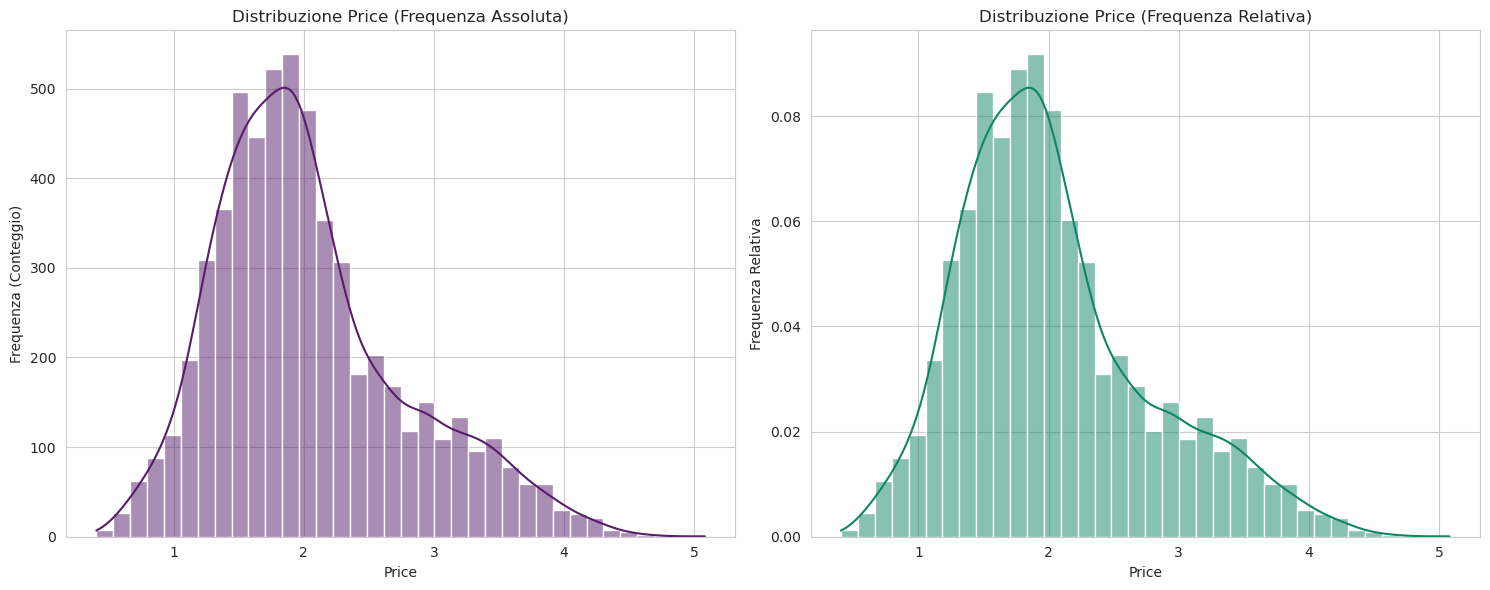

In [1224]:
n = len(price)
rice_bins = int(2 * n**(1/3))

print(f"Num. of bins: {rice_bins}")

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1) 
ax1 = sns.histplot(
    x=price, 
    bins=rice_bins, 
    kde=True, 
    color="#571c6a",
    edgecolor='white'
)
plt.title(f'Distribuzione Price (Frequenza Assoluta)')
plt.ylabel('Frequenza (Conteggio)')
plt.xlabel('Price')

plt.subplot(1, 2, 2) 
ax2 = sns.histplot(
    x=price, 
    bins=rice_bins, 
    kde=True, 
    stat='probability',
    color="#108564",
    edgecolor='white'
)
plt.title(f'Distribuzione Price (Frequenza Relativa)')
plt.ylabel('Frequenza Relativa')
plt.xlabel('Price')

plt.tight_layout()
plt.show()

Questa distribuzione è molto diversa dalla normale. Notiamo un alto picco e un'asimmetria molto accentuata. Deduciamo che le auto di lusso sono molto meno vendute delle utilitarie. La moda si aggira tra 0 e 5 Lahks, con oltre il 40% delle auto. 

Calcoliamo Skewness e Kurtosis:

In [1225]:
print(f"Skewness: {price.skew():.2f}")
print(f"Kurtosis: {price.kurtosis():.2f}")

Skewness: 0.79
Kurtosis: 0.30


Questa coda è causata da un gruppo di auto con prezzi molto, molto alti (auto di lusso, sportive, o veicoli specializzati).

Picco Appuntito: C'è una concentrazione eccezionale di auto vendute attorno al prezzo modale (il prezzo più frequente). Ciò significa che c'è un prezzo "target" o una fascia di prezzo in cui la maggior parte delle vendite si aggrega.

Code Ponderose (Outliers): La Kurtosis positiva estrema indica che, rispetto a una distribuzione Normale, ci sono molti più outliers (valori estremi) di quanto ci si aspetterebbe. Combinando questo con l'alta Skewness, deduciamo che la maggior parte di questi outliers si trova nell'estremità superiore, confermando che i veicoli di lusso sono non solo rari, ma hanno prezzi che si discostano in modo massiccio dalla norma.

Deduciamo che c'è un ampio mercato di massa, i veicoli economici e accessibili sono i più venduti. Mentre esiste un mercato di auto di lusso o in generale costose il cui prezzo si discosta di tantissimo rispetto la media.

Dato che la distribuzione del prezzo è così estrema, dovremmo applicare una trasformazione dei dati (come il logaritmo) in modo da poter essere usato per modelli statistici, come regressione lineare.

<Axes: >

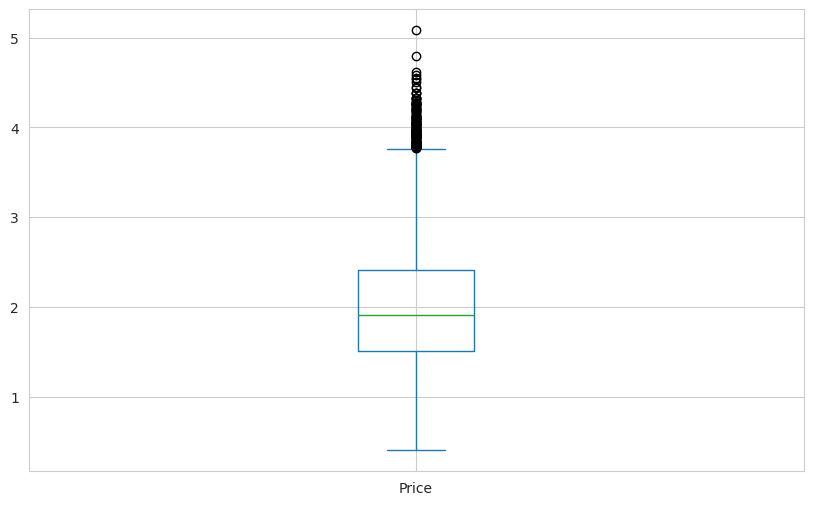

In [1226]:
price.plot.box(figsize=(10,6))

Il boxplot riflette questa grande asimmetria, la maggior parte dei dati è schiacciata verso il basso.

**Analisi Multivariata**

Innanzitutto riassumiamo le analisi fatte da Filippo:
- Vi è una correlazione molto positiva tra Power e Price
- Vi è una correlazione molto positiva tra Engine e Price
- Sia Power e sia Engine influenzano Price allo stesso modo, questo perché più un auto è potente e più costa;
- Vi è una correlazione negativa tra Age e Price, banalmente più l'auto invecchia e meno costa;
- Vi è una correlazione negativa tra Mileage e Price, motori più efficienti sono legati ad auto più economiche e non troppo potenti, auto costone sono molto potenti e consumano di più;
- Vi è una correlazione negativa tra Owner_Type e Price, un auto che ha avuto più proprietari potrebbe essere in condizioni peggiori oppure essere più vecchia;
- Auto di lusso costano più rispetto ad altre marche
- La location non sembra influenzare il prezzo;
- Sembra che brand più costosi utilizzino maggiormente il cambio automatico per le proprie auto;
- Sembra che auto più costose utilizzino il Diesel invece della benzina.

Coefficiente di Correlazione (r): -0.55


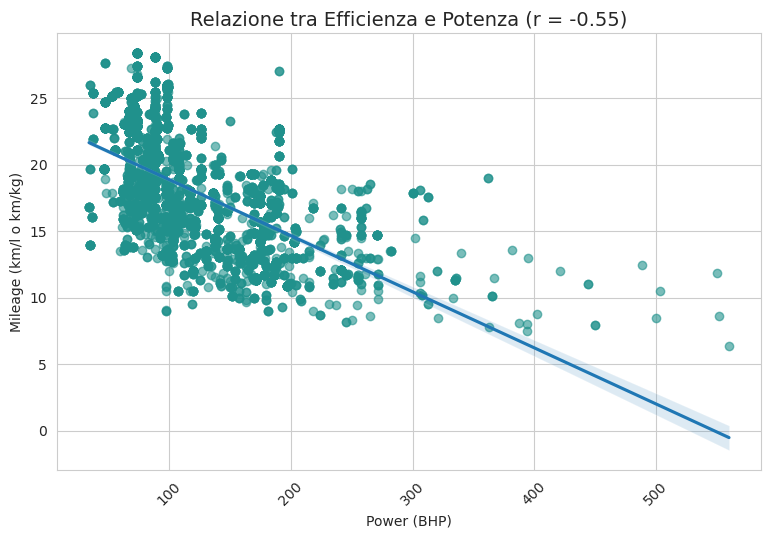

In [1227]:
correlation_r =df['Mileage'].corr(df['Power'])
print(f"Coefficiente di Correlazione (r): {correlation_r:.2f}")

# --- 3. Schema Grafico Standard (Regplot) ---
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2) # Seguiamo la struttura subplot del tuo schema

# Usiamo regplot per avere scatter plot (punti) e linea di regressione (tendenza)
ax = sns.regplot(
    x=df['Power'], 
    y=df['Mileage'], 
    scatter_kws={'color': '#20918c', 'alpha': 0.6},
    marker='o'
)

# Titoli e Rotazione
plt.title(f'Relazione tra Efficienza e Potenza (r = {correlation_r:.2f})', fontsize=14)
plt.ylabel('Mileage (km/l o km/kg)')
plt.xlabel('Power (BHP)')

# Rotazione etichette come da schema
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Sembra che in media le auto Manuali siano di più delle auto Automatiche.

**Inferenza Statistica**

Dobbiamo partire da delle osservazioni sorte durante l'analisi:
- Sembra che il prezzo medio delle auto automatiche sia più alto rispetto alle manuali;
- Sembra che auto che hanno avuto meno proprietari valgano di più in media;
- Sembra che auto più potenti in media utilizzano trasmissione automatica;
- Ci aspettiamo che auto più potenti siano meno efficienti
- Controllo sulla media della potenza dell'auto

Le ultime due le inseriamo per completezza ma sono meno importanti

Osservazione 1: Sembra che auto più costose in media utilizzano trasmissione automatica.

In [1228]:
df = pd.read_csv('dataframe.csv')

In [ ]:
from scipy import stats

print(f"Gruppi di trasmissione: {df['Transmission'].unique()}\n")

group_per_transmission =  df.groupby('Transmission')['Price']
mean = group_per_transmission.mean()
std = group_per_transmission.std()

count = group_per_transmission.count()
std_err = std/np.sqrt(count)

confidence_level = 0.95

interval_manual = stats.norm.interval(confidence_level, loc=mean['Manual'], scale=std_err['Manual'])
interval_automatic = stats.norm.interval(confidence_level, loc=mean['Automatic'], scale=std_err['Automatic'])

print("---- Media per gruppo di tramissione ----")
print(f"Manual:\t\t {mean['Manual']:.2f}\nAutomatic:\t {mean['Automatic']:.2f}\n")

print("---- Std Dev per gruppo di tramissione ----")
print(f"Manual:\t\t {std['Manual']:.2f}\nAutomatic:\t {std['Automatic']:.2f}\n")

print("---- Std Err per gruppo di tramissione ----")
print(f"Manual:\t\t {std_err['Manual']:.2f}\nAutomatic:\t {std_err['Automatic']:.2f}\n")

print("---- Confidence Interval di price per gruppo di tramissione ----")
print(f"Manual:\t\t ({interval_manual[0]:.2f}, {interval_manual[1]:.2f})")
print(f"Automatic:\t ({interval_automatic[0]:.2f}, {interval_automatic[1]:.2f})\n")

Gruppi di trasmissione: ['Manual' 'Automatic']

---- Media per gruppo di tramissione ----
Manual:		 1.74
Automatic:	 2.77

---- Std Dev per gruppo di tramissione ----
Manual:		 0.48
Automatic:	 0.75

---- Std Err per gruppo di tramissione ----
Manual:		 0.01
Automatic:	 0.02

---- Confidence Interval di price per gruppo di tramissione ----
Manual:		 (1.73, 1.76)
Automatic:	 (2.74, 2.81)



Eseguiamo un Two Sample T-Test verificare l'affermazione vista in precedenza, ovvero se c'è una differenza significatica tra la media del prezzo delle auto Automatiche e quello delle Manuali.

In [1230]:
import numpy as np
from scipy import stats

manual = df[df['Transmission'] == 'Manual']['Price']
automatic = df[df['Transmission'] == 'Automatic']['Price']

t_stat, p_value = stats.ttest_ind(manual, automatic)

alpha = 0.05

print(f"Test statistic: {t_stat:0.2f}")
print(f"Significance level: {alpha:0.2f}")
print(f"P-value: {p_value:0.2f}")

if p_value < alpha:
    print("Conclusione: c'è una differenza significativa tra la media del prezzo delle auto Automatiche e Manuali.")
else:
    print("Conclusione: non c'è una differenza significativa tra la media del prezzo delle auto Automatiche e Manuali.")

Test statistic: -62.65
Significance level: 0.05
P-value: 0.00
Conclusione: c'è una differenza significativa tra la media del prezzo delle auto Automatiche e Manuali.


Abbiamo concluso che in media un auto Automatica costa il 57% in più di un auto Manuale, una differenza di circa 1 Lahks.

Osservazione 2:

Calcoliamo gli intervalli di confidenza per le proporzioni di auto Automatiche e Manuali:

In [1231]:
import statsmodels.api as sm
import numpy as np

group_per_transmission =  df.groupby('Transmission')['Price']
count = group_per_transmission.count()

total = df['Transmission'].count()

confidence_level = 0.95

proportion = count['Manual'] / total
conf_interval_man = sm.stats.proportion_confint(count['Manual'], total, alpha=1-confidence_level, method='normal')
conf_interval_aut = sm.stats.proportion_confint(count['Automatic'], total, alpha=1-confidence_level, method='normal')

print(f"---- Sample Proportion ----")
print(f"Manual:\t\t {proportion:.2f}")
print(f"Automatic:\t {1 - proportion:.2f}\n")

print("---- Confidence Interval of Proportion ----")
print(f"Manual:\t\t ({conf_interval_man[0]:.2f}, {conf_interval_man[1]:.2f})")
print(f"Automatic:\t ({conf_interval_aut[0]:.2f}, {conf_interval_aut[1]:.2f})\n")

---- Sample Proportion ----
Manual:		 0.71
Automatic:	 0.29

---- Confidence Interval of Proportion ----
Manual:		 (0.70, 0.72)
Automatic:	 (0.28, 0.30)



Il test statistico più adatto a determinare se nella popolazione ci sono più auto manuali rispetto alle automatiche è il z-Test:

In [1232]:
import statsmodels.api as sm
import numpy as np

group_per_transmission =  df.groupby('Transmission')['Price']
count = group_per_transmission.count()

total_count = count['Manual'] + count['Automatic']

null_hypothesis = 0.50
alpha = 0.05

z_stat, p_value = sm.stats.proportions_ztest(count=count['Manual'], nobs=total_count,  value=null_hypothesis)

prop_manual = count['Manual'] / total_count

print("---- Test Z per proporzione Trasmissione ----")
print(f"Proporzione Ipotizzata:\t {null_hypothesis}")
print(f"Proporzione Manuale: {prop_manual:.4f}\n")

print(f"Z-Test statistic: {z_stat:0.2f}")
print(f"Significance level: {alpha:0.2f}")
print(f"P-value: {p_value:0.2f}")

if p_value < alpha:
    print("Conclusione: c'è una differenza significativa tra le proporzioni di auto Manuali e Automatiche.")
else:
    print("Conclusione: non c'è una differenza significativa tra le proporzioni di auto Manuali e Automatiche.")

---- Test Z per proporzione Trasmissione ----
Proporzione Ipotizzata:	 0.5
Proporzione Manuale: 0.7088

Z-Test statistic: 35.19
Significance level: 0.05
P-value: 0.00
Conclusione: c'è una differenza significativa tra le proporzioni di auto Manuali e Automatiche.


Concludiamo che nella popolazione le auto Manuali sono di più rispetto alle Automatiche.

Osservazione 3: Il tipo di proprietario influenza il prezzo.

In [1236]:
from scipy import stats

# TO DO: Generalizza

print(f"Gruppi di proprietario: {df['Owner_Type'].unique()}\n")

group_per_owner =  df.groupby('Owner_Type')['Price']
mean = group_per_owner.mean()
std = group_per_owner.std()

count = group_per_owner.count()
std_err = std/np.sqrt(count)

confidence_level = 0.95

interval_firt_ow = stats.norm.interval(confidence_level, loc=mean['First'], scale=std_err['First'])
interval_second_ow = stats.norm.interval(confidence_level, loc=mean['Second'], scale=std_err['Second'])
interval_third_ow = stats.norm.interval(confidence_level, loc=mean['Third'], scale=std_err['Third'])

print("---- Media per gruppo di Owner_Type ----")
print(f"Fisrt:\t\t {mean['First']:.2f}")
print(f"Second:\t\t {mean['Second']:.2f}")
print(f"Third:\t\t {mean['Third']:.2f}\n")

print("---- Std Dev per gruppo di Owner_Type ----")
print(f"First:\t\t {std['First']:.2f}")
print(f"Second:\t\t {std['Second']:.2f}")
print(f"Third:\t\t {std['Third']:.2f}\n")

print("---- Std Err per gruppo di tramissione ----")
print(f"First:\t\t {std_err['First']:.2f}")
print(f"Second:\t\t {std_err['Second']:.2f}")
print(f"Third:\t\t {std_err['Third']:.2f}\n")

print("---- Confidence Interval di price per gruppo di tramissione ----")
print(f"First:\t\t ({interval_firt_ow[0]:.2f}, {interval_firt_ow[1]:.2f})")
print(f"Second:\t\t ({interval_second_ow[0]:.2f}, {interval_second_ow[1]:.2f})")
print(f"Third:\t\t ({interval_third_ow[0]:.2f}, {interval_third_ow[1]:.2f})\n")

Gruppi di proprietario: ['First' 'Second' 'Third']

---- Media per gruppo di Owner_Type ----
Fisrt:		 2.09
Second:		 1.84
Third:		 1.51

---- Std Dev per gruppo di Owner_Type ----
First:		 0.73
Second:		 0.76
Third:		 0.68

---- Std Err per gruppo di tramissione ----
First:		 0.01
Second:		 0.03
Third:		 0.07

---- Confidence Interval di price per gruppo di tramissione ----
First:		 (2.07, 2.11)
Second:		 (1.79, 1.89)
Third:		 (1.38, 1.64)



Sembra che il prezzo medio cambi in base al tipo di propreitario: meno proprietari ha l'auto e più vale.

Eseguiamo un Two Sample T-Test ma solamente tra i campioni 'First' e 'Second', essendo quelli più presenti nel dataset:

In [1237]:
import numpy as np
from scipy import stats

first = df[df['Owner_Type'] == 'First']['Price']
second = df[df['Owner_Type'] == 'Second']['Price']

t_stat, p_value = stats.ttest_ind(first, second)

alpha = 0.05

print(f"Test statistic: {t_stat:0.2f}")
print(f"Significance level: {alpha:0.2f}")
print(f"P-value: {p_value:0.2f}")

if p_value < alpha:
    print("Conclusione: c'è una differenza significativa tra la media del prezzo delle auto First owner rispetto alle Second owner.")
else:
    print("Conclusione: non c'è una differenza significativa tra la media del prezzo delle auto First owner rispetto alle Second owner.")

Test statistic: 9.36
Significance level: 0.05
P-value: 0.00
Conclusione: c'è una differenza significativa tra la media del prezzo delle auto First owner rispetto alle Second owner.
